In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch import optim
from typing import Tuple, List
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DEVICE = "cpu"

In [3]:
train = MNIST("data", train=True)
test = MNIST("data", train=False)
train, test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test)

In [4]:
image_1 = train[0][0]
image_1

In [5]:
size_of_images = image_1.width * image_1.height
size_of_images

784

In [6]:
# Turn the images into tensors
train_x = torch.stack([ToTensor()(i[0]) for i in train]).to(DEVICE)
train_y = torch.tensor([i[1] for i in train]).to(DEVICE)

test_x = torch.stack([ToTensor()(i[0]) for i in test]).to(DEVICE)
test_y = torch.tensor([i[1] for i in test]).to(DEVICE)

In [7]:
class MNISTNeuralNetwork(nn.Module):
    def __init__(self, dims: List[int]):
        super().__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(dims[i], dims[i + 1]) for i in range(len(dims) - 1)]
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))

        x = self.layers[-1](x)

        return self.softmax(x)


model = MNISTNeuralNetwork([size_of_images, 128, 10]).to(DEVICE)

In [8]:
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=64)

test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [9]:
learning_rate = 0.1
epochs = 100
log_interval = 10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

losses: torch.Tensor = torch.zeros(epochs, device=DEVICE)
for epoch in range(epochs):
    total_loss = 0
    for images, labels in train_dataloader:
        # Images is a batch of images <batch_size>
        images = images.view(-1, size_of_images) # Flatten the images
        optimizer.zero_grad() # Reset the gradients
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    total_loss /= len(train_dataloader)
    losses[epoch] = total_loss

    if epoch % log_interval == 0:
        print(f"Epoch {epoch} Loss: {total_loss}")

Epoch 0 Loss: 1.8971749856782112
Epoch 10 Loss: 1.5286709062580361
Epoch 20 Loss: 1.5093055878366743
Epoch 30 Loss: 1.4983826128404532
Epoch 40 Loss: 1.4906160373931754
Epoch 50 Loss: 1.485747740466966
Epoch 60 Loss: 1.4822106672756707
Epoch 70 Loss: 1.4797020464309498
Epoch 80 Loss: 1.4778378718951617
Epoch 90 Loss: 1.4763997458954101


<Axes: >

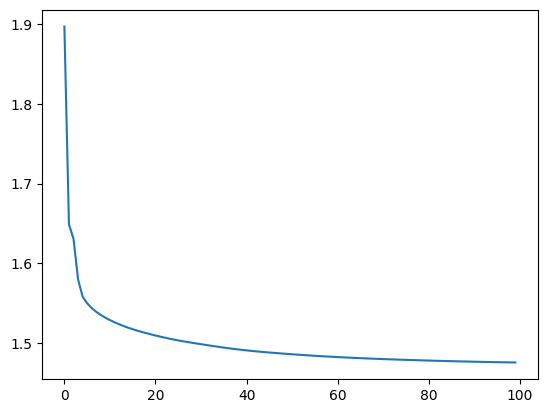

In [10]:
sns.lineplot(x=range(epochs), y=losses.cpu().numpy())

In [11]:
# Test the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        # Images is a batch of images <batch_size>
        images = images.view(-1, size_of_images) # Flatten the images
        output = model(images) # Get the output of the model
        _, predicted = torch.max(output.data, 1) # Get the index of the max log-probability (softmax)
        total += labels.size(0) # Add the number of labels in the batch
        correct += (predicted == labels).sum().item() # Add the number of correct predictions

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")

Accuracy of the network on the 10000 test images: 97.41%
